In [451]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib as mpl
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Set the working directory
root_dir = "Datasets"

# Read dataset and save it in a dataframe
df = pd.read_csv(os.path.join(root_dir, "dermatology.data"), header=None, delimiter=",")
print(df.shape)

(366, 35)


### Dataset review

- **Dataset presentation:** The dataset consists of clinical cases of patients that suffer from erythemato-squamous diseases.

- **File conversion:** We did not need to convert our plain text, we used the read_csv function from pandas.

- **Entry and attribute count:** The dataset consists of 366 entries, each of which has 34 attributes. All of them are ordinal, except the family history which is binary and age which is numeric.

- **Indexes and headers:** There are no row indexes or column headers.

- **Class labels:** Class labels (found in column 35) are integers from 1 to 6, that represent psoriasis, seboreic dermatitis, lichen planus,pityriasis rosea, cronic dermatitis, and pityriasis rubra pilaris respectively.

- **Missing values:** There are 8 missing values in the age column and they represent 8/366= 0.022% of the entries.

- **Class count:** As we can see from the table below, the dataset is not balanced.

    | Class      | Number of instances | Percentages |
    | ----------- | ----------- | ----------- |
    | psoriasis      | 112       | 30.6% |
    | seboreic dermatitis   | 61        | 16.6% |
    | lichen planus         | 72       | 19.6% |
    | pityriasis rosea   | 49        | 13.4% |
    | cronic dermatitis         | 52       | 14.3% |
    | pityriasis rubra pilaris    | 20        | 5.5% |


      




### Dataset split

- **Splitting method:** We used the train_test_split function from sklearn.model_selection to split the dataset into training and testing sets. We used a 70/30 split, meaning that 70% of the dataset was used for training and 30% for testing.



In [452]:
from sklearn.model_selection import train_test_split

# Split the dataset into labels and features
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

#split the df into train and test sets with 30% of the data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)



print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(256, 34)
(110, 34)
(256,)
(110,)


### Missing values

- **Missing values treatment:** Since we had missing values in the age column, we decided to replace them with the median of the column. We did this because the column is numeric and the median is a good approximation of the missing values. We also decided to replace the missing values with the median because the number of missing values is small compared to the number of entries.
To achieve this, we first replaced the missing values with NaN, then we calculated the median of the column and finally we replaced the NaN values with the median.


In [453]:
from sklearn.impute import SimpleImputer


# replace ? with NaN
Χ_train = X_train.replace('?', np.nan)
Χ_test = X_test.replace('?', np.nan)

# Use SimpleImputer to replace missing values with the median of the column
imp = SimpleImputer(missing_values=np.nan, strategy='median')

X_train = imp.fit_transform(Χ_train)
X_test = imp.fit_transform(Χ_test)


# Save the datasets to retrieve them later
X_train_initial = X_train
X_test_initial = X_test
y_train_initial = y_train
y_test_initial = y_test


### Feature types

- **Feature types:** All of the features are ordinal, except the family history which is binary and age which is numeric. We did not need to convert any of the features to a different type.

### Classification

- **Classifiers:** We will test the following classifiers: dummy, Gaussian Naive Bayes,  k-nearest neighbors, Logistic Regression.

- **Evaluation metrics:** We will use the accuracy and the F1 score to evaluate the performance of the classifiers.

- **Cross-validation:** We will use 10-fold cross-validation to evaluate the performance of the classifiers.





#### Out-of-the-box performance



In [454]:
# import dummy,GNB,kNN,LR
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# import metrics
from sklearn.metrics import accuracy_score, f1_score

# import cross validation 
from sklearn.model_selection import cross_validate


# define the classifiers
oob_clf1 = DummyClassifier()
oob_clf2 = GaussianNB()
oob_clf3 = KNeighborsClassifier()
oob_clf4 = LogisticRegression()

# fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
out_of_the_box_df = pd.DataFrame(columns=['Accuracy OOB', 'F1 Score OOB'])
for clf in [oob_clf1, oob_clf2, oob_clf3, oob_clf4]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    out_of_the_box_df.loc[clf.__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]


|                      |   Accuracy OOB |   F1 Score OOB |
|:---------------------|---------------:|---------------:|
| DummyClassifier      |       0.281818 |       0.12392  |
| GaussianNB           |       0.854545 |       0.846423 |
| KNeighborsClassifier |       0.909091 |       0.909087 |
| LogisticRegression   |       0.990909 |       0.990961 |

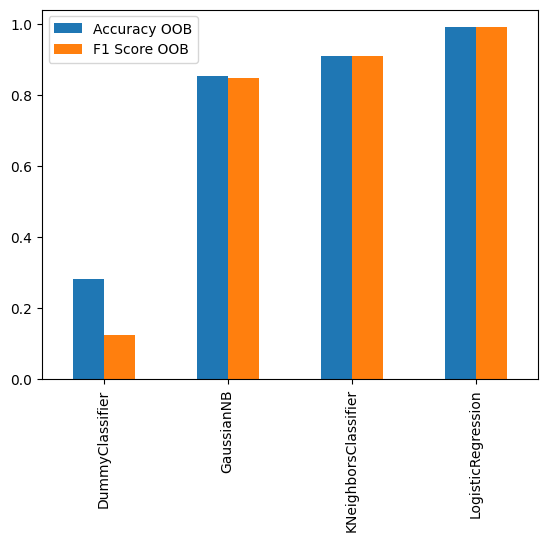

In [455]:
from IPython.display import Markdown as md



# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = out_of_the_box_df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = out_of_the_box_df.to_markdown()
md(markDownTableResults)



#### Result analysis

- **Dummy classifier:** The dummy classifier does not perform well in neither metric. This is expected because the dataset is not balanced and the dummy classifier always predicts the most frequent class.

- **Gaussian Naive Bayes:** The Gaussian Naive Bayes classifier performs better than the dummy classifier in both metrics. This is expected because the dataset is not balanced and the Gaussian Naive Bayes classifier is a good classifier for imbalanced datasets.

- **k-nearest neighbors:** The k-nearest neighbors classifier performs better than the dummy classifier and has similar results to GNB in both metrics. 

- **Logistic Regression:** The Logistic Regression classifier performs slightly better than all the other classifier in both metrics.



### Optimizations

#### Data preprocessing

- **Dataset balancing:** Since the dataset is not balanced, we decided to balance it by using a RandomOverSampler. This way we will have the same number of instances for each class, without losing any information. We chose this approach because we do not have a sufficient number of instances to use undersampling.





In [456]:
# redefine the classifiers

pre_clf1 = DummyClassifier()
pre_clf2 = GaussianNB()
pre_clf3 = KNeighborsClassifier()
pre_clf4 = LogisticRegression()


# oversample the minority class of the training set
from imblearn.over_sampling import RandomOverSampler

# define the oversampler
ros = RandomOverSampler()

# new training set after oversampling
X_train, y_train = ros.fit_resample(X_train, y_train)


- **Feature selection:** We user the default VarianceThreshold selector (threshold = 0) and no features were excluded.

In [457]:
from sklearn.feature_selection import VarianceThreshold

# define the variance threshold
selector = VarianceThreshold()

print(X_train.shape)
X_train = selector.fit_transform(X_train)
print(X_train.shape)


(486, 34)
(486, 34)


- **Feature scaling:** We used the MinMaxScaler to scale all the columns. We did this because the age column has a large range of values and the MinMaxScaler will scale them in the range of [0,1]. Also, the ordinal features will be scaled in the range of [0,1]. This way, all the features will be in the same range and the classifier will not be biased towards the age column.

In [458]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import  MinMaxScaler 
from sklearn import preprocessing

# το ίδιο με  min max scaling
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)



- **Dimensionality reduction:** We tested for every possible value of n_components and we applied PCA with the optimal value. 


In [459]:
from sklearn.decomposition import PCA


max_score = 0
best_n = 1

for n in range(1, 34):
    pca = PCA(n_components=n)

    X_train_PCA = pca.fit_transform(X_train)
    X_test_PCA = pca.transform(X_test)

    scores = []

    # fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
    for clf in [pre_clf2, pre_clf3, pre_clf4]:
        clf.fit(X_train_PCA, y_train)
        y_pred = clf.predict(X_test_PCA)
        
        # mean of accuracy score and f1_score  
        scores.append((accuracy_score(y_test, y_pred) + f1_score(y_test, y_pred, average='weighted')) / 2)
    
    score = min(scores)
    
    if(score > max_score):
        max_score = score
        best_n = n


pca = PCA(n_components=best_n)

# after finding the best n_components, we fit the PCA on the whole dataset
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)




- **Demonstration:** After our data preprocessing phase, we fit the same out-of-the-box classifiers to the new datasets and we test on the test set. There is an obvious increase in both performance metrics.

|                      |   Accuracy |   F1 Score |
|:---------------------|-----------:|-----------:|
| DummyClassifier      |   0.281818 |   0.12392  |
| GaussianNB           |   0.972727 |   0.972883 |
| KNeighborsClassifier |   0.981818 |   0.981818 |
| LogisticRegression   |   0.972727 |   0.972883 |

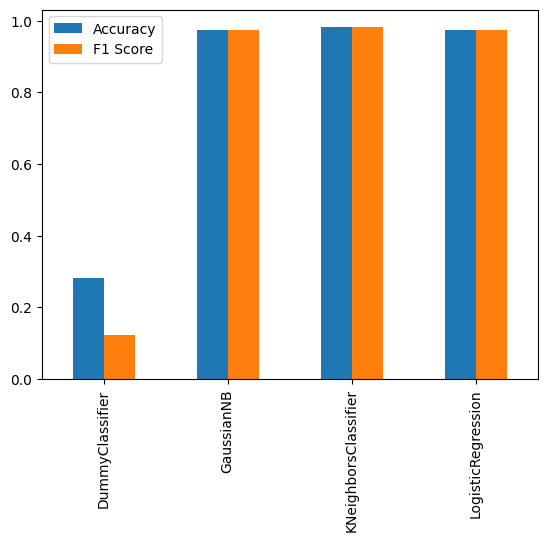

In [460]:
# fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
df = pd.DataFrame(columns=['Accuracy', 'F1 Score'])
for clf in [pre_clf1, pre_clf2, pre_clf3, pre_clf4]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    df.loc[clf.__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]



from IPython.display import Markdown as md


# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = df.to_markdown()
md(markDownTableResults)



#### Pipeline

- **Pipeline:** We created a pipeline that applies the data preprocessing steps and then fits the classifiers. We used the pipeline to evaluate the performance of the classifiers on the training set. We also used the pipeline to evaluate the performance of the classifiers on the test set.


In [461]:
# retrieve the initial datasets (missing values have been treated)
X_train = X_train_initial
X_test = X_test_initial
y_train = y_train_initial
y_test = y_test_initial

from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA

# Initialize the transformers without hyperparameters
selector = VarianceThreshold()
scaler = MinMaxScaler()
ros = RandomOverSampler()
pca = PCA()


# Initialize the classifiers without hyperparameters
pipe_clf1 = DummyClassifier()
pipe_clf2 = GaussianNB()
pipe_clf3 = KNeighborsClassifier()
pipe_clf4 = LogisticRegression(max_iter=1000000)

# Initialize the pipelines
pipe1 = Pipeline([ ('ros', ros), ('selector', selector), ('scaler', scaler), ('pca', pca), ('clf', pipe_clf1)], memory = 'tmp')
pipe2 = Pipeline([ ('ros', ros), ('selector', selector), ('scaler', scaler), ('pca', pca), ('clf', pipe_clf2)], memory = 'tmp')
pipe3 = Pipeline([ ('ros', ros), ('selector', selector), ('scaler', scaler), ('pca', pca), ('clf', pipe_clf3)], memory = 'tmp')
pipe4 = Pipeline([ ('ros', ros), ('selector', selector), ('scaler', scaler), ('pca', pca), ('clf', pipe_clf4)], memory = 'tmp')


- **Demonstration:** After we initialize our pipelines, without providing any hyperparameters, we fit them to our training data and predict .

|                      |   Accuracy |   F1 Score |
|:---------------------|-----------:|-----------:|
| DummyClassifier      |   0.281818 |   0.12392  |
| GaussianNB           |   0.9      |   0.896479 |
| KNeighborsClassifier |   0.963636 |   0.963975 |
| LogisticRegression   |   0.990909 |   0.990961 |

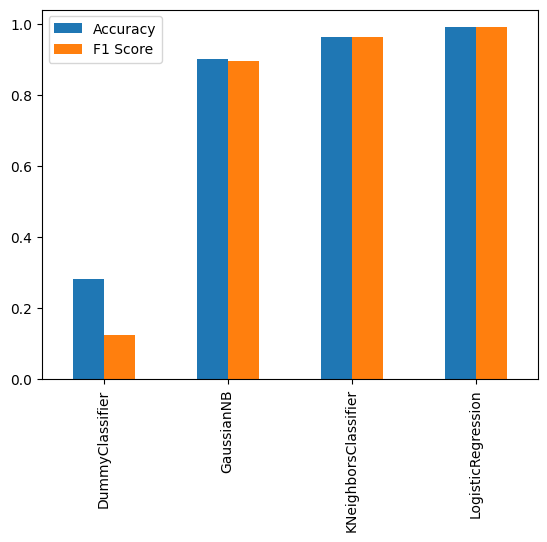

In [462]:
# fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
df = pd.DataFrame(columns=['Accuracy', 'F1 Score'])
for pipe in [pipe1, pipe2, pipe3, pipe4]:
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    df.loc[pipe.named_steps['clf'].__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]



from IPython.display import Markdown as md


# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = df.to_markdown()
md(markDownTableResults)



#### GridSearchCV

- **GridSearchCV:** We utilized the pipelines that we previously declared and we used GridSearchCV to find the optimal hyperparameters for each classifier. The hyperparameter values that we tested were picked based on intuition and previous results. We used the same evaluation metrics as before and we used 10-fold cross-validation. We also used the same scoring metrics as before.


In [463]:
# retrieve the initial datasets (missing values have been treated)
X_train = X_train_initial
X_test = X_test_initial
y_train = y_train_initial
y_test = y_test_initial


from sklearn.model_selection import GridSearchCV

# define the parameters for the grid search
vthreshold = [0, 50, 100, 150]
n_components = range(1, 34)



# DummyClassifier

# define the grid search
grid_dummy = dict(selector__threshold=vthreshold, pca__n_components=n_components)

dummy_estimator = GridSearchCV(pipe1, grid_dummy, cv=10, scoring='accuracy', n_jobs=-1)

# fit the grid search
dummy_estimator.fit(X_train, y_train)

# ------------------------------

# GaussianNB

var_smoothing = np.logspace(0,-9, num=5)

# define the grid search
grid_gaussian = dict(selector__threshold=vthreshold, pca__n_components=n_components, clf__var_smoothing=var_smoothing)

gaussian_estimator = GridSearchCV(pipe2, grid_gaussian, cv=10, scoring='accuracy', n_jobs=-1)

# fit the grid search
gaussian_estimator.fit(X_train, y_train)

# ------------------------------


# K Nearest Neighbors

# kNN hyperparameter
k = [1, 3, 5, 7, 9, 15, 21, 27, 33] 

# define the grid search
grid_KNN = dict(selector__threshold=vthreshold, pca__n_components=n_components, clf__n_neighbors=k)

kNN_estimator = GridSearchCV(pipe3, grid_KNN, cv=10, scoring='accuracy', n_jobs=-1)

# fit the grid search
kNN_estimator.fit(X_train, y_train)

# ------------------------------

# Logistic Regression

# Logistic Regression hyperparameters
C = [ 0.01, 0.1, 1, 10, 100, 1000]

# define the grid search
grid_logistic = dict(selector__threshold=vthreshold, pca__n_components=n_components, clf__C=C)

logistic_estimator = GridSearchCV(pipe4, grid_logistic, cv=10, scoring='accuracy', n_jobs=-1)

# fit the grid search
logistic_estimator.fit(X_train, y_train)

# ------------------------------






GridSearchCV(cv=10,
             estimator=Pipeline(memory='tmp',
                                steps=[('ros', RandomOverSampler()),
                                       ('selector', VarianceThreshold()),
                                       ('scaler', MinMaxScaler()),
                                       ('pca', PCA()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100, 1000],
                         'pca__n_components': range(1, 34),
                         'selector__threshold': [0, 50, 100, 150]},
             scoring='accuracy')

- **Demonstration:** After we initialize our gridsearches, we fit them to our training data and predict.

|                      |   Accuracy |   F1 Score |
|:---------------------|-----------:|-----------:|
| DummyClassifier      |   0.281818 |   0.12392  |
| GaussianNB           |   0.972727 |   0.972347 |
| KNeighborsClassifier |   0.972727 |   0.973094 |
| LogisticRegression   |   0.981818 |   0.982003 |

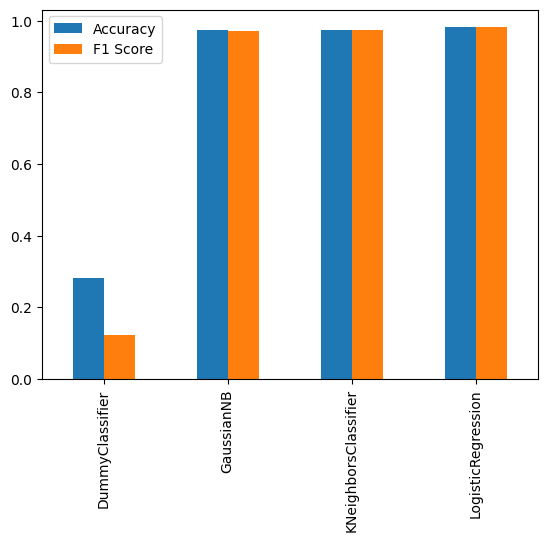

In [464]:
# fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
df = pd.DataFrame(columns=['Accuracy', 'F1 Score'])
for est in [dummy_estimator, gaussian_estimator, kNN_estimator, logistic_estimator]:
    y_pred = est.best_estimator_.predict(X_test)
    df.loc[est.best_estimator_.named_steps['clf'].__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]



from IPython.display import Markdown as md


# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = df.to_markdown()
md(markDownTableResults)

### Results and conclusions

#### Comparative results

- **Comparative table:** We created a table to compare the performance of all out of the box classifiers to the best classifiers that we produced by the GridSearchCV. We can see that the optimized classifiers perform significantly better than the out-of-the-box classifiers in both metrics, when we look at the GaussianNB and kNN classifiers. As far as the Logistic regression estimator is concerned, we can see that the hyperparameter tuning did not improve its performance in most cases. Additionally, we can see a slight decline in performance compared to the out of the box logistic estimator. This is probably due to the fact that the logistic estimator is already a very good estimator and it does not need much hyperparameter tuning to perform well.   
In the table we also included the training and testing times for every optimized estimator. We noticed that there was a considerable difference in the testing time of the kNN classifier. Given that we are working on a relatively small dataset and that classifier sees a considerable increase in prediction time in larger datasets, we can say that he is the least performant time-wise. We did not notice any other significant differences in the training and testing times of the other classifiers.

- **Comparative graph:** We also plotted a bar chart to show the above data in a graphical way.



|                      |   Accuracy OOB |   F1 Score OOB |   Accuracy BEST |   F1 Score BEST |   Train time |   Test time |
|:---------------------|---------------:|---------------:|----------------:|----------------:|-------------:|------------:|
| DummyClassifier      |       0.281818 |       0.12392  |        0.281818 |        0.12392  |   0.00563884 | 0.000181913 |
| GaussianNB           |       0.854545 |       0.846423 |        0.972727 |        0.972347 |   0.00433588 | 0.000242233 |
| KNeighborsClassifier |       0.909091 |       0.909087 |        0.972727 |        0.973094 |   0.00389624 | 0.0258918   |
| LogisticRegression   |       0.990909 |       0.990961 |        0.981818 |        0.982003 |   0.00558305 | 0.000155926 |

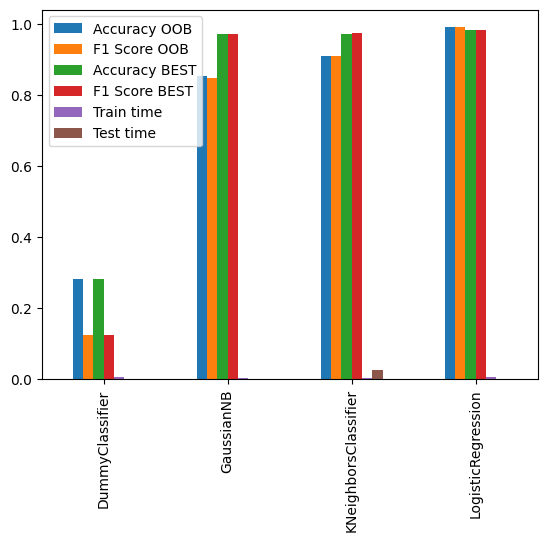

In [465]:
from sklearn.metrics import plot_confusion_matrix
import time


df = pd.DataFrame(columns=['Accuracy BEST', 'F1 Score BEST','Train time', 'Test time'])
for est in [dummy_estimator, gaussian_estimator, kNN_estimator, logistic_estimator]:
    trainStart = time.time()
    est.best_estimator_.fit(X_train, y_train)
    trainEnd = time.time()

    testStart = time.time()
    y_pred = est.best_estimator_.predict(X_test)
    testEnd = time.time()

    df.loc[est.best_estimator_.named_steps['clf'].__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted'), trainEnd - trainStart, testEnd - testStart]


# merge out_of_the_box_df with df 
final_df = out_of_the_box_df.merge(df, left_index=True, right_index=True)


from IPython.display import Markdown as md


# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = final_df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = final_df.to_markdown()
md(markDownTableResults)

#### Confusion matrix

We plotted the confusion matrices of the best and worst classifiers to see how it performs on each class. We can see that even the best classifier has noticeable error rate in some classes. This is expected because the dataset is not balanced and the classifier is biased towards the most frequent class. The worst classifier has multiple classes that it considerably misclassifies, as expected from out least performant estimator.

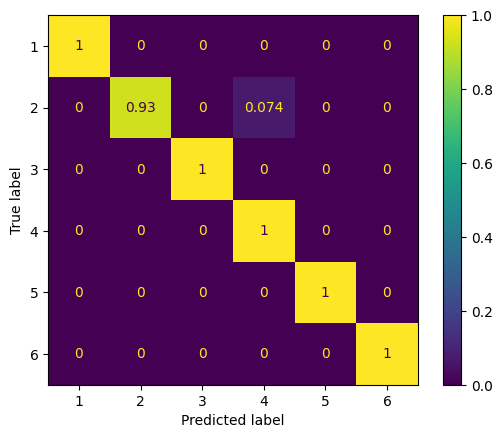

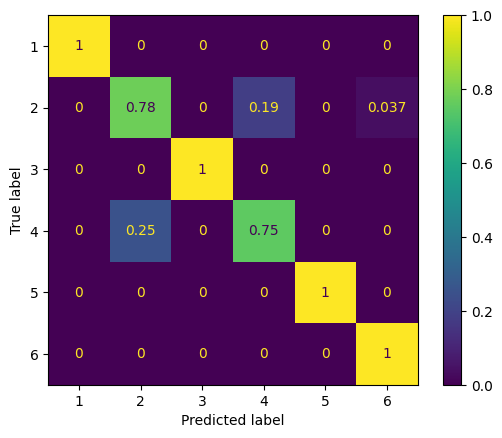

In [466]:

# plot confusion matrix for the best estimator
plot_confusion_matrix(logistic_estimator.best_estimator_, X_test, y_test, normalize='true')

# plot confusion matrix for the worst estimator
plot_confusion_matrix(oob_clf3, X_test, y_test, normalize='true')


#### Final conclusion

The best classifier, according to our tests, is the out of the box LogisticRegression classifier. It has the highest accuracy and F1 score in testing sets accross all experiments. This is expected because the LogisticRegression classifier is a very good classifier and it does not need much hyperparameter tuning to perform well. Additionaly, we have no indication that there would be any problems with the training, testing and prediction times in case the dataset gets larger.